# Japanese Female Face Expression

## Parameters

In [1]:
import os

BASE_DIR = '/Users/efraflores/Desktop/EF/Diplo/JAFFE'
print(os.listdir(BASE_DIR))
IMAGE_RESIZE = (92,92)
INPUT_SHAPE = list(IMAGE_RESIZE) + [3]
FC_LAYERS = [128,128,67]
DROPOUT = 0.1
BATCH_SIZE = 2
EPOCHS = 21

['cnn_jaffe.json', '.DS_Store', 'images', 'cnn_jaffe_transfer_weights.h5', 'data.csv', 'cnn_jaffe_weights.h5', 'cnn_jaffe_transfer.json', 'val']


In [2]:
import pandas as pd
pd.read_csv(os.path.join(BASE_DIR,'data.csv')).sample(4)

,filepath,student,facial_expression
210,images/YM.SU1.58.tiff,YM,surprise
142,images/NM.NE3.94.tiff,NM,neutral
202,images/YM.HA2.53.tiff,YM,happiness
76,images/KR.HA1.74.tiff,KR,happiness


In [3]:
CSV_FILE = 'data.csv'
PATH_COL = 'filepath'
LABEL_COL = 'facial_expression'
CLASS_TYPE = 'categorical'

## Functions

In [4]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tono(a = 1000, b = 700, play_time_seconds = 1, framerate = 4410):
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t) + np.sin(b*t), rate = framerate, autoplay=True)

In [5]:
import PIL
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

def images_from_df(base_dir,csv,path_column,label_column,class_type,
                   img_resize,batch_size,preprocess=False,
                   train_set='training_set',test_set='test_set'):
    
    df = pd.read_csv(os.path.join(base_dir,csv))
    X_train, X_test = train_test_split(df[[path_column,label_column]],
                                       train_size=0.8,random_state=22)
    if preprocess:
        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                           rotation_range=90,
                                           horizontal_flip=True,
                                           vertical_flip=True)
    else:
        train_datagen = ImageDataGenerator()
    training_set = train_datagen.flow_from_dataframe(dataframe=X_train,
                                                     directory=base_dir,
                                                     x_col=path_column,
                                                     y_col=label_column,
                                                     target_size=IMAGE_RESIZE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode=class_type)
    test_datagen = ImageDataGenerator()
    testing_set = test_datagen.flow_from_dataframe(dataframe=X_test,
                                                   directory=base_dir,
                                                   x_col=path_column,
                                                   y_col=label_column,
                                                   target_size=IMAGE_RESIZE,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode=class_type)
    return training_set,testing_set,list(set(df[label_column]))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, LeakyReLU

def transf_model(base_model, dropout, fc_layers, classes):
    #Freeze the weights, the main point of transfer learning!
    for layer in base_model.layers:
        layer.trainable = False
    #Receive the flat output to work in your own neural network
    x = Flatten()(base_model.output)
    for fc in fc_layers:
        x = Dense(fc)(x) #New Fully-Connected layer
        x = LeakyReLU()(x) #Break linearity
        x = Dropout(dropout)(x) #Avoid overfitting
    #Last layer
    predictions = Dense(1 if len(classes)<3 else len(classes),
                        activation='sigmoid' if len(classes)<3 else 'softmax')(x)
    #Merge both models
    return Model(inputs=base_model.input, outputs=predictions)

In [7]:
import numpy as np
from keras.preprocessing import image

def predict_cnn(model,train_set,image_path,image_file,img_resize):
    dict_class = {y:x for x,y in train_set.class_indices.items()}
    test_image = image.load_img(os.path.join(image_path,image_file),
                                target_size = img_resize)
    display(test_image)
    test_image = np.expand_dims(image.img_to_array(test_image),axis=0)
    pred = pd.DataFrame(model.predict(test_image)[0],index=dict_class.values(),columns=[''])
    return pred.sort_values('',0,0).style.format('{:.2%}')

## Preprocessing

In [8]:
training_set,test_set,class_list = images_from_df(base_dir=BASE_DIR,
                                                  csv=CSV_FILE,
                                                  path_column=PATH_COL,
                                                  label_column=LABEL_COL,
                                                  class_type=CLASS_TYPE,
                                                  img_resize=IMAGE_RESIZE,
                                                  batch_size=BATCH_SIZE)
print(f'Classes are: {class_list}')

Found 170 validated image filenames belonging to 7 classes.
Found 43 validated image filenames belonging to 7 classes.
Classes are: ['angry', 'fear', 'disgust', 'surprise', 'neutral', 'sadness', 'happiness']


## Arquitecture

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50

#Load the pre-trained CNN without the fully-connected layers
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=INPUT_SHAPE)

#Merge it with yout own neural network
final_model = transf_model(base_model, 
                           dropout=DROPOUT, 
                           fc_layers=FC_LAYERS,
                           classes=class_list)
print(final_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 92, 92, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 98, 98, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 46, 46, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 46, 46, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Training

In [10]:
from tensorflow.keras.optimizers import Adam
final_model.compile(optimizer=Adam(),
                    loss=CLASS_TYPE+'_crossentropy',
                    metrics=CLASS_TYPE+'_accuracy')
final_model.fit(training_set,validation_data=test_set,epochs=EPOCHS)

Epoch 1/21
85/85 [==============================] - 11s 92ms/step - loss: 15.7910 - categorical_accuracy: 0.1518 - val_loss: 5.1056 - val_categorical_accuracy: 0.3256
Epoch 2/21
85/85 [==============================] - 7s 81ms/step - loss: 8.0371 - categorical_accuracy: 0.2483 - val_loss: 1.7152 - val_categorical_accuracy: 0.5349
Epoch 3/21
85/85 [==============================] - 8s 89ms/step - loss: 3.0851 - categorical_accuracy: 0.5213 - val_loss: 5.4078 - val_categorical_accuracy: 0.2791
Epoch 4/21
85/85 [==============================] - 8s 92ms/step - loss: 4.7091 - categorical_accuracy: 0.4011 - val_loss: 6.9823 - val_categorical_accuracy: 0.2558
Epoch 5/21
85/85 [==============================] - 8s 99ms/step - loss: 3.1267 - categorical_accuracy: 0.5369 - val_loss: 3.3762 - val_categorical_accuracy: 0.4186
Epoch 6/21
85/85 [==============================] - 8s 100ms/step - loss: 2.9424 - categorical_accuracy: 0.5043 - val_loss: 3.0402 - val_categorical_accuracy: 0.5116
Epoch 7

The val_accuracy can be low because of the different proportion of classes vs the trainset

## Save the model

In [11]:
#First, save the architecture
with open(os.path.join(BASE_DIR,'cnn_jaffe_transfer.json'), 'w') as f:
    f.write(final_model.to_json())

#Then, the paramaters learned by itself
final_model.save_weights(os.path.join(BASE_DIR,'cnn_jaffe_transfer_weights.h5'))

/Users/efraflores/Desktop/ann/venv/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
from keras.models import model_from_json

#Now, we can use this model whenever we want!
with open(os.path.join(BASE_DIR,'cnn_jaffe_transfer.json'), 'r') as f:
    model = model_from_json(f.read())

model.load_weights(os.path.join(BASE_DIR,'cnn_jaffe_transfer_weights.h5'))
model.compile(optimizer='adam',
              loss=CLASS_TYPE+'_crossentropy',
              metrics=CLASS_TYPE+'_accuracy')

## Predict

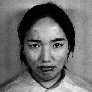

,
angry,100.00%
surprise,0.00%
sadness,0.00%
happiness,0.00%
disgust,0.00%
neutral,0.00%
fear,0.00%


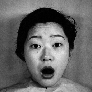

,
surprise,100.00%
neutral,0.00%
angry,0.00%
disgust,0.00%
fear,0.00%
happiness,0.00%
sadness,0.00%


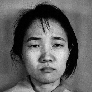

,
sadness,100.00%
disgust,0.00%
neutral,0.00%
happiness,0.00%
surprise,0.00%
angry,0.00%
fear,0.00%


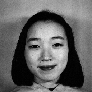

,
happiness,99.99%
sadness,0.01%
neutral,0.00%
surprise,0.00%
fear,0.00%
angry,0.00%
disgust,0.00%


3 minutos con 11.33 segundos


In [13]:
#Predict the class of each image in the specified path
predict_path = os.path.join(BASE_DIR,'val')
for file in [x for x in os.listdir(predict_path) if x[-4:] in ('.jpg','.png','jpeg','tiff')]:
    display(predict_cnn(final_model,training_set,predict_path,file,IMAGE_RESIZE))

time_exp(time.time()-start)
tono()